# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [3]:
bbc.sample(5)

,category,text
1055,tech,hotspot users gain free net calls people using...
2167,tech,no re-draft for eu patent law a proposed euro...
716,entertainment,fantasy book wins hollywood deal a british aut...
1908,politics,jowell rejects las vegas jibe the secretary ...
1464,business,bmw cash to fuel mini production less than fou...


In [4]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
bbc['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

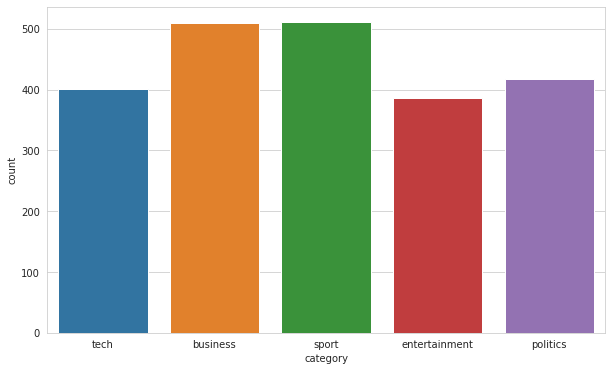

In [6]:
plt.figure(figsize=(10,6))
sns.countplot(bbc.category)
plt.show()

### Data Preparation

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [8]:
X_train, X_test, y_train, y_test = train_test_split(bbc['text'], bbc['category'], test_size=0.2, shuffle=True)

In [9]:
# tokenize
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)
tokenize.fit_on_texts(X_train)
X_train = tokenize.texts_to_matrix(X_train)
X_test = tokenize.texts_to_matrix(X_test)

In [10]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [11]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Train model

In [12]:
batch_size = 32
epochs = 2

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1)

Epoch 1/2
51/51 [==============================] - 0s 9ms/step - loss: 0.4247 - accuracy: 0.8870 - val_loss: 0.1103 - val_accuracy: 0.9775
Epoch 2/2
51/51 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.9919 - val_loss: 0.1064 - val_accuracy: 0.9775


In [13]:
# Evaluate the accuracy of our trained model
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

14/14 [==============================] - 0s 3ms/step - loss: 0.1392 - accuracy: 0.9618
Test loss: 0.13918077945709229
Test accuracy: 0.9617977738380432


### Fine-tunning

In [18]:
def run_experiment(batch_size, epochs):
  print('batch size: {}, epochs: {}'.format(
      batch_size, epochs))
  model = Sequential()
  model.add(Dense(512, input_shape=(max_words,)))
  model.add(Activation('relu'))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.1)
  score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=0)
  print('\tTest loss:', score[0])
  print('\tTest accuracy:', score[1])

In [19]:
batch_size = 32
epochs = 2
run_experiment(batch_size, epochs)

batch size: 32, epochs: 2
	Test loss: 0.13277210295200348
	Test accuracy: 0.9707865118980408


In [22]:
for i in range(1, 10):
  run_experiment(16, i * 2)
  run_experiment(32, i * 2)

batch size: 16, epochs: 2
	Test loss: 0.155588299036026
	Test accuracy: 0.9595505595207214
batch size: 32, epochs: 2
	Test loss: 0.1387505978345871
	Test accuracy: 0.9573033452033997
batch size: 16, epochs: 4
	Test loss: 0.13381430506706238
	Test accuracy: 0.9617977738380432
batch size: 32, epochs: 4
	Test loss: 0.1434003710746765
	Test accuracy: 0.9595505595207214
batch size: 16, epochs: 6
	Test loss: 0.13562838733196259
	Test accuracy: 0.966292142868042
batch size: 32, epochs: 6
	Test loss: 0.13949410617351532
	Test accuracy: 0.9573033452033997
batch size: 16, epochs: 8
	Test loss: 0.15907739102840424
	Test accuracy: 0.9573033452033997
batch size: 32, epochs: 8
	Test loss: 0.14534738659858704
	Test accuracy: 0.9528089761734009
batch size: 16, epochs: 10
	Test loss: 0.1712987869977951
	Test accuracy: 0.9573033452033997
batch size: 32, epochs: 10
	Test loss: 0.14144235849380493
	Test accuracy: 0.9617977738380432
batch size: 16, epochs: 12
	Test loss: 0.17045240104198456
	Test accuracy: